## **Image Classification - Fruits Recognition:**

The images where made with in our lab’s environment under different scenarios. All the images on a clear background with resolution of 320×258 pixels. Used HD Logitech web camera to took the pictures. During collecting this database, we created all kind of challenges, which, we have to face in real-world recognition scenarios in supermarket and fruit shops such as light, shadow, sunshine, pose variation, to make our model robust for, it might be necessary to cope with illumination variation, camera capturing artifacts, specular reflection shading and shadows. We tested our model’s robustness in all scenarios and it perform quit well.

**Dataset Link:** https://www.kaggle.com/chrisfilo/fruit-recognition

#### Downloading the dataset from kaggle:

In [ ]:
# Uploading dataset from kaggle
from google.colab import files
files.upload()

# downloading google api client
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# download api link
!kaggle datasets download -d chrisfilo/fruit-recognition


Saving kaggle.json to kaggle.json
100% 7.91G/7.92G [02:40<00:00, 52.1MB/s]
100% 7.92G/7.92G [02:41<00:00, 52.8MB/s]


In [ ]:
# unzipping the files
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/fruit-recognition.zip", 'r')
zip_ref.extractall("/content/Dataset")
zip_ref.close()

#### Importing libraries:

In [ ]:
import os
import shutil 
import random
import matplotlib.pyplot as plt
import cv2
from PIL.Image import Image
import numpy as np

np.random.seed(42)

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Preparing the dataset for the model:    
To check the availability of images in each labels and split the dataset for training, validation and for testing by creating folder for all three in the format
                                       

In [ ]:
# number of labels 
labels= os.listdir("/content/Dataset")
print("Number of labels: ",len(labels))
labels = sorted(labels, reverse= False)
labels

Number of labels:  15


['Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes',
 'muskmelon']

In [ ]:
# getting the number of images present in each labels
root_dir = "/content/Dataset"

total_images= 0
for filename in labels:
  label_dir= os.path.join(root_dir,filename)
  label_len= len(os.listdir(label_dir))
  total_images += label_len
  print("{}: {} images".format(filename, label_len))
print()
print("Total Images: ",total_images)

Apple: 7 images
Banana: 3027 images
Carambola: 2080 images
Guava: 4 images
Kiwi: 4 images
Mango: 4154 images
Orange: 3012 images
Peach: 2629 images
Pear: 3012 images
Persimmon: 2072 images
Pitaya: 2501 images
Plum: 2298 images
Pomegranate: 2167 images
Tomatoes: 2171 images
muskmelon: 2078 images

Total Images:  31216


*Apple, Guava, kiwi folders contains only 7+4+4= 15 images. Let's check inside whether it is a folder or just contains 15 images ...*

In [ ]:
labels_to_check= ['Apple', 'Guava', 'Kiwi']

for label in labels_to_check:
  label_dir= os.path.join(root_dir, label)
  print("Label: ",label)
  print(os.listdir(label_dir))

Label:  Apple
['Apple B', 'Apple F', 'Apple D', 'Total Number of Apples', 'Apple C', 'Apple E', 'Apple A']
Label:  Guava
['guava B', 'Guava total', 'guava A', 'guava total final']
Label:  Kiwi
['Kiwi C', 'kiwi A', 'Kiwi B', 'Total Number of Kiwi fruit']


*As we can see that the folders contains subfolders which is not needed for our classification problem.*

Lets create a function that removes unwanted folders from the disk and only keeps the final one needed..

In [ ]:
# removing unwanted folders

remove_apple= ['Apple C', 'Apple F', 'Apple A', 'Apple B', 'Apple D', 'Apple E']
remove_guava= ['guava B', 'guava A', 'guava total final']
remove_kiwi= ['Kiwi C', 'Kiwi B', 'kiwi A']

def remove_folders(dir, folders_to_remove):
  # """Function takes directory and folder names in a list to remove"""
  for folder in os.listdir(dir):
    if folder in folders_to_remove:
      shutil.rmtree(os.path.join(dir,folder))
  
  # getting the labels from the folder inside
  remain_folder= os.listdir(dir)[0]
  
  # files present in the folder
  files= os.listdir(os.path.join(dir,remain_folder))
  
  # moving the files from one folder to another
  source= os.path.join(dir, remain_folder)
  dest= dir
  for filename in files:
    shutil.move(os.path.join(source , filename), os.path.join(dest , filename))
  
  os.rmdir(os.path.join(dir, remain_folder))

In [ ]:
# executing the function for all three folders
remove_folders(dir= "/content/Dataset/Apple", folders_to_remove= remove_apple)
remove_folders(dir= "/content/Dataset/Guava", folders_to_remove= remove_guava)
remove_folders(dir= "/content/Dataset/Kiwi", folders_to_remove= remove_kiwi)

In [ ]:
# Now getting the total image size on each labels
total_images= 0
labels_dic= {}
for filename in labels:
  label_dir= os.path.join(root_dir,filename)
  label_len= len(os.listdir(label_dir))
  labels_dic[filename]= label_len
  total_images += label_len
  print("{}: {} images".format(filename, label_len))
print()
print("Total Images: ",total_images)

Apple: 5024 images
Banana: 3027 images
Carambola: 2080 images
Guava: 12552 images
Kiwi: 4173 images
Mango: 4154 images
Orange: 3012 images
Peach: 2629 images
Pear: 3012 images
Persimmon: 2072 images
Pitaya: 2501 images
Plum: 2298 images
Pomegranate: 2167 images
Tomatoes: 2171 images
muskmelon: 2078 images

Total Images:  52950


In [ ]:
# sorting the labels in the ascending order with respect of number of images present
sorted(labels_dic.items(), key= lambda x: x[1])

[('Persimmon', 2072),
 ('muskmelon', 2078),
 ('Carambola', 2080),
 ('Pomegranate', 2167),
 ('Tomatoes', 2171),
 ('Plum', 2298),
 ('Pitaya', 2501),
 ('Peach', 2629),
 ('Orange', 3012),
 ('Pear', 3012),
 ('Banana', 3027),
 ('Mango', 4154),
 ('Kiwi', 4173),
 ('Apple', 5024),
 ('Guava', 12552)]

In [ ]:
# creating train as an empty folder inside Dataset and create subfolders with labels as folder name

def make_dir(root_path, dir_name, label_names):
  """
  Creates a directory and sub-directory for each labels 
  Return None
  """
  # making train directory inside root folder
  os.mkdir(os.path.join(root_path, dir_name))
  
  folder_path= os.path.join(root_path, dir_name)

  # creating sub folders
  for label in label_names:
    os.mkdir(os.path.join(folder_path, label))
  
  print("Created {} folder and all sub-folders inside".format(dir_name))
  return folder_path

# creating train and validation folder  
train_dir= make_dir(root_path= root_dir, dir_name= "train", label_names= labels)
valid_dir= make_dir(root_path= root_dir, dir_name= "valid", label_names= labels)

# creating test folder
os.mkdir(os.path.join(root_dir, "test"))

Created train folder and all sub-folders inside
Created valid folder and all sub-folders inside


In [ ]:
# Moving images into the respective sub-folders in train folder
def move_to_train_valid(source_dir,dest_dir,labels, n):
  """Move n number of images from source directory to destination directory
    The function is applicable for both train and validation folders
  parameters: 
  source_dir - source directory where images present
  dest_dir   - destination directory where images need to be moved
  labels     - subfolder names in a list 
  n          - total number of images to move from source to destination

  Returns None
  """

  for label in labels:
    src_path= os.path.join(source_dir,label)
    dst_path= os.path.join(dest_dir, label)
    n_random_files= np.random.choice(os.listdir(src_path), size= n, replace= False)

    for filename in n_random_files:
      shutil.move(os.path.join(src_path, filename), os.path.join(dst_path, filename))

  print("{} files are moved from source to destination folder".format(n))


def move_to_test(source_dir,dest_dir,labels,n):
  """Move n numbers of images from source to destination .The function is applicable for test images"""
  for label in labels:
    src_path= os.path.join(source_dir, label)

    if len(os.listdir(src_path)) >= n: 
      n_random_files= np.random.choice(os.listdir(src_path), size= n, replace= False)
      
      for filename in n_random_files:
        
        shutil.move(os.path.join(src_path, filename), os.path.join(dest_dir, filename))
  print("{} files from each labels are moved to test folder".format(n))

In [ ]:
# moving images to train and valid folder ie,. to the label subfolders
move_to_train_valid(source_dir= root_dir, dest_dir= os.path.join(root_dir, "train"), labels= labels, n= 1865)
move_to_train_valid(source_dir= root_dir, dest_dir= os.path.join(root_dir, "valid"), labels= labels, n= 207)

# moving images to test folder
move_to_test(source_dir= root_dir, dest_dir= os.path.join(root_dir, "test"), labels= labels, n= 220)

1865 files are moved from source to destination folder
207 files are moved from source to destination folder
220 files from each labels are moved to test folder


In [ ]:
# moving images to test folder: running this two times increases the test images 
move_to_test(source_dir= root_dir, dest_dir= os.path.join(root_dir, "test"), labels= labels, n= 220)

220 files from each labels are moved to test folder


In [ ]:
# deleting other directories (subfolders) from the Dataset folder

for label in labels:
  shutil.rmtree(os.path.join(root_dir, label))

In [ ]:
# number of test images 
n_train= sum([len(os.listdir(os.path.join(root_dir, "train", label))) for label in labels])
n_valid= sum([len(os.listdir(os.path.join(root_dir, "valid", label))) for label in labels])
n_test= len(os.listdir(os.path.join(root_dir, "test")))

print("Train_images length : {}".format(n_train))
print("Validation images length : {}".format(n_valid))
print("Test_images length : {}".format(n_test))

Train_images length : 27975
Validation images length : 3105
Test_images length : 5500


After preprocessing all the images in the folder, we get images in the format of train,valid with label names as subfolders and test folder containing random images. Finally, the dataset is split up as,         
**Train images** : 27975             
**Validation** : 3105          
**Test images** : 5500

### Exploring the dataset:           
In this, we create a tensor dataset and train, validation loader with a batchsize to split the images into batches so that the training takes place through batches of images. Also,we will visualize the images.

In [ ]:
root_dir= "/content/Dataset"
labels= os.listdir(os.path.join(root_dir, "train"))
labels

['Carambola',
 'muskmelon',
 'Apple',
 'Peach',
 'Banana',
 'Orange',
 'Pear',
 'Pitaya',
 'Mango',
 'Pomegranate',
 'Guava',
 'Persimmon',
 'Kiwi',
 'Plum',
 'Tomatoes']

In [ ]:
# path for train, validation directory

train_dir= os.path.join(root_dir, "train")
valid_dir= os.path.join(root_dir, "valid")
test_dir= os.path.join(root_dir, "test")

In [ ]:
# Transforms are common image transformations. They can be chained together using Compose
data_transform= transforms.Compose(
                              [transforms.Resize(size= (224,224)),
                               transforms.ToTensor()])

In [ ]:
# creating tensors of train and validation dataset which performs transformations and returns all the images in the same size
train_dataset = ImageFolder(root= train_dir, transform= data_transform,)
valid_dataset = ImageFolder(root= valid_dir, transform= data_transform)

In [ ]:
print("Train dataset: ",train_dataset)
print("Validation dataset: ",valid_dataset)

Train dataset:  Dataset ImageFolder
    Number of datapoints: 27975
    Root location: /content/Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Validation dataset:  Dataset ImageFolder
    Number of datapoints: 3105
    Root location: /content/Dataset/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
# DataLoader module from torch to split dataset further into batches to work effieciently with gradient descent
batch_size= 64

train_loader= DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True,
                         num_workers= 2, pin_memory= True)
valid_loader= DataLoader(dataset= valid_dataset, batch_size= batch_size*2, num_workers= 2, pin_memory= True)

torch.Size([64, 3, 224, 224])


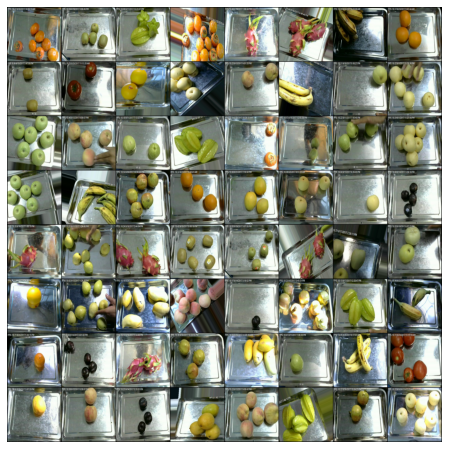

In [ ]:
# Visualizing all images from single batch
for images, _ in train_loader:
  print(images.shape)
  plt.figure(figsize= (8,8))
  plt.axis("off")
  plt.imshow(make_grid(images, nrow= 8).permute((1,2,0)))
  break

### Convolution Network Model:    
Building own Convolution Neural Network model architecture by creating a seperate class and calling the built-in modules from pytorch. **torch.nn** package contains modules, extensible classes and all the required components to build neural networks.

Smaller kernel sizes will reduce computational time and weight sharing.

In [ ]:
# creating a class to build a colvolution network model
class FruitRecognition(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes= num_classes

    # creating a model architecture
    self.network= nn.Sequential(
        # convolution layers
        nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding= 1),  # output: (32,224,224)
        nn.ReLU(),
        nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1), # output: (64,224,224)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride= 2), # output: (64,112,112)  

        nn.Conv2d(in_channels= 64, out_channels= 128,kernel_size= 3, stride= 1, padding= 1), # output: (128,112,112)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # output: (128,56,56)
        nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 3, stride= 1, padding= 1), # output: (128,112,112) 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # output: (128,28,28)
        nn.Dropout2d(0.4),

        nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, stride= 1, padding= 1), # output: (256,28,28)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # output: (256,14,14)
        nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size= 3, stride= 1, padding= 1), # output: (256,14,14)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # output: (256,7,7)   
        nn.Dropout2d(0.4),

        # Fully connected layer
        nn.Flatten(), # output: 256*7*7= (12544,)
        nn.Linear(in_features= 256*7*7, out_features= 256), # output : 256*12544= (3211264,)
        nn.ReLU(),
        nn.Dropout2d(p= 0.4),
        nn.Linear(in_features= 256, out_features= 128), # output : 128*3211264= (411041792,)
        nn.ReLU(),
        nn.Dropout2d(p= 0.4),
        nn.Linear(in_features= 128, out_features= self.num_classes)
      )
  
  def forward(self,xb):
    return self.network(xb)

  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
    
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))  

In [ ]:
# defining the model
model= FruitRecognition(num_classes= len(labels))

In [ ]:
# model summary
print(model)

FruitRecognition(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.4, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(k

### Model Training:
The model is given for training with the dataset that we provide. The model learns the complex structure of features using weights and biases and update those parameters using gradient descent algorithm.          

Before training the model,the model and the data to be set to the GPU device using **torch.device**. To check the availability of device is to use **torch.cuda.is_available**

##### i. Training on GPU settings:

In [ ]:
# checking whether the gpu is available or not
torch.cuda.is_available()

True

In [ ]:
# # check the device available for further processing of data . GPU or cpu and adds the device to the functionality
# def default_device():
#   """adds device= cuda, if gpu is available, else cpu"""
#   if torch.cuda.is_available():
#     return torch.device("cuda")
#   else:
#     return torch.device("cpu")

# # getting the data into the device memory
# def to_device(data, device):
#   """Move tensors to existing device memory"""
  
#   if isinstance(data, (list,tuple)):
#     return [to_device(x, device) for x in data]
#   return data.to(device, non_blocking= True)

# # class for DataLoader that wraps the batches of data into the device memory
# class DeviceDataLoader():
#   def __init__(self,dl, device):
#     self.dl= dl
#     self.device= device

#   def __iter__(self):
#     """yeilds a batch of data after moving it to device"""
#     for b in self.dl:
#       yield to_device(b, self.device)

#   def __len__(self):
#     "length of batches"
#     return len(self.dl)

In [ ]:
# available device
# device= default_device()
# device

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [ ]:
# # moving the tensors into the torch's default device memory
# train_loader = DeviceDataLoader(train_loader, default_device())
# valid_loader = DeviceDataLoader(valid_loader, default_device())

# # making model to the gpu device availability
# model= to_device(model, default_device())

model.to(device)

FruitRecognition(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.4, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(k

In [ ]:
# check for the device in a batch
for xb,yb in train_loader:
  print("xb device: ",xb.device)
  print(yb)
  break

xb device:  cpu
tensor([ 8,  1,  9,  7,  9,  9, 14, 12,  0, 14,  5, 12,  6,  4,  9, 11,  5,  5,
         1,  3,  8,  0, 11,  0,  0,  2,  0, 12,  0, 11,  0,  4, 10,  9,  8, 11,
         6,  9,  0, 14,  8,  7, 13, 12,  8, 12,  4, 11, 10, 11,  7, 11,  5,  9,
        12, 10,  7, 12,  2, 11, 14,  4, 10, 12])


##### ii. Loss function and accuracy:

In [ ]:
def accuracy(output, actual):
  """Returns the accuracy in a percentage
  parameters:
  output :  output from the last layer (linear layer)
  actual : ground-truth target label 
  """
  _, pred= torch.max(output,dim= 1)
  return torch.sum(pred == actual).item()/len(pred)



In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
n_epochs = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (valid_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'Fruit_recogn.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/10], Step [0/438], Loss: 2.7095
Epoch [1/10], Step [20/438], Loss: 2.6757
Epoch [1/10], Step [40/438], Loss: 2.4483
Epoch [1/10], Step [60/438], Loss: 2.5027
Epoch [1/10], Step [80/438], Loss: 2.1543
Epoch [1/10], Step [100/438], Loss: 2.3311
Epoch [1/10], Step [120/438], Loss: 2.1080
Epoch [1/10], Step [140/438], Loss: 2.1839
Epoch [1/10], Step [160/438], Loss: 2.1017
Epoch [1/10], Step [180/438], Loss: 2.1033
Epoch [1/10], Step [200/438], Loss: 2.0446
Epoch [1/10], Step [220/438], Loss: 2.0474
Epoch [1/10], Step [240/438], Loss: 2.0759
Epoch [1/10], Step [260/438], Loss: 1.7595
Epoch [1/10], Step [280/438], Loss: 1.6811
Epoch [1/10], Step [300/438], Loss: 1.7102
Epoch [1/10], Step [320/438], Loss: 1.8574
Epoch [1/10], Step [340/438], Loss: 1.5820
Epoch [1/10], Step [360/438], Loss: 1.6320
Epoch [1/10], Step [380/438], Loss: 1.7891
Epoch [1/10], Step [400/438], Loss: 1.5137
Epoch [1/10], Step [420/438], Loss: 1.7100

train loss: 2.0257, train acc: 23.8463
validation 

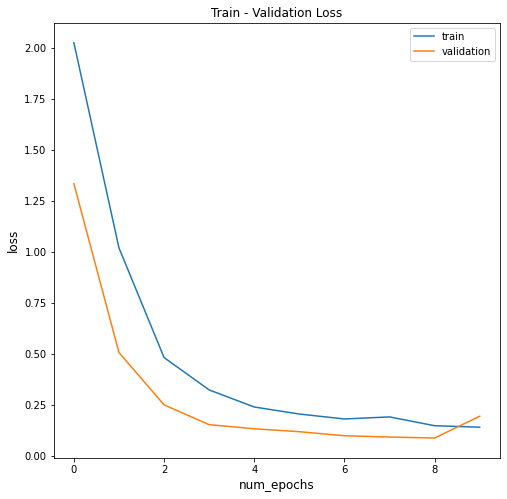

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

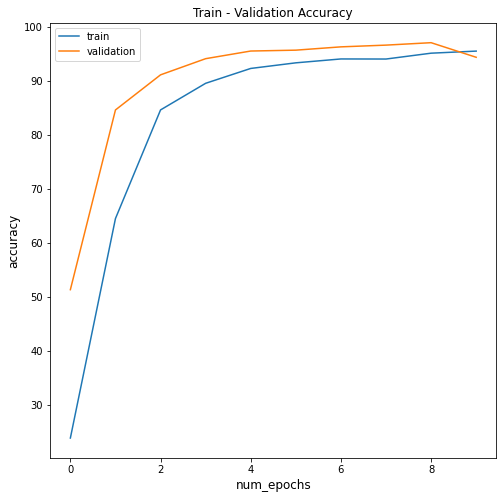

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

Our current model reaches an **validation accuracy of 95%**,which is not bad. To improve further, we need to reduce epochs or perform some augmentation to increase the dataset

Predicting the images:

In [ ]:
def to_device(data, device):
  """Move tensors to existing device memory"""
  
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)

In [ ]:
def predict_image(img, model,labels):
    labels_final= sorted(labels)
    xb = to_device(img.unsqueeze_(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return labels_final[preds[0].item()]

In [ ]:
test_files= os.listdir(test_dir)

# randomly takin 10 images from the test folder
random_test_files= np.random.choice(test_files, size= 10, replace= False)

/content/Dataset/test/Banana01135.png


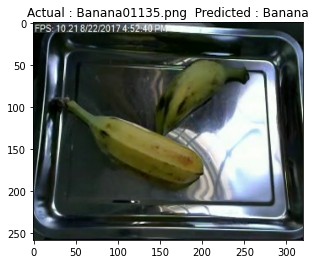

/content/Dataset/test/Orange00219.png


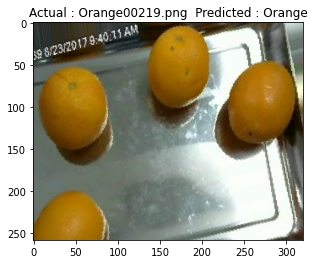

/content/Dataset/test/Apple 03798.png


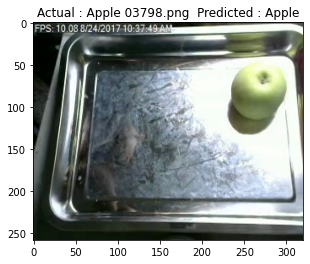

/content/Dataset/test/Peach002164.png


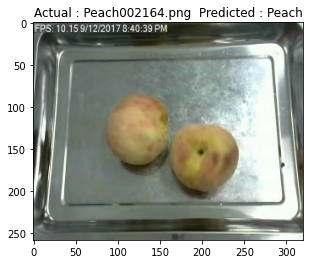

/content/Dataset/test/Apple 02069.png


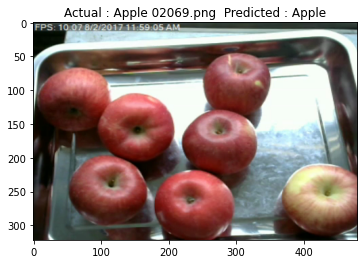

/content/Dataset/test/Orange002491.png


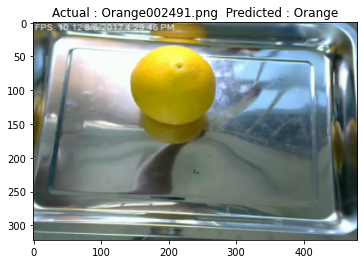

/content/Dataset/test/pear_0_3194.png


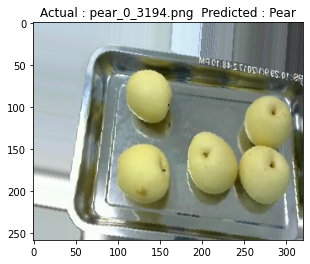

/content/Dataset/test/Kiwi003837.png


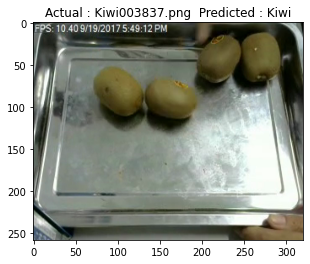

/content/Dataset/test/Kiwi003281.png


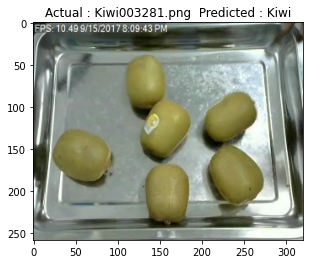

/content/Dataset/test/GuavaπÇé1824 resized resized.png


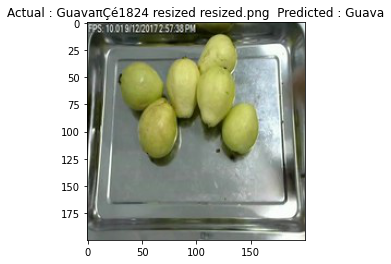

In [ ]:
from PIL import Image
for filename in random_test_files:
  image_path= os.path.join(test_dir, filename)
  print(image_path)
  test_image= Image.open(image_path)
  test_np= np.array(test_image, dtype= np.uint8)
  test_image= data_transform(test_image)
  # convert to tensorr

  pred_label= predict_image(test_image, model, labels)
  plt.title("Actual : {}  Predicted : {}".format(filename[:len(pred_label)], pred_label))
  plt.imshow(test_np)
  plt.show()